# DFL - Decision-Focused Learning for VRPs
## Using SPO+

In [1]:
from util import *
import torch
import numpy as np
from solver import GurobiSolver
from spo import CostPredictor, SPOplus

# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

In [2]:
vrps_train = [parse_datafile(f'../data/cvrp_1000_10_5_2/instance_{i}') for i in range(800)]
vrps_test = [parse_datafile(f'../data/cvrp_1000_10_5_2/instance_{i}') for i in range(800, 1000)]

Parsing datafile: ../data/cvrp_1000_10_5_2/instance_0...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_1...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_2...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_3...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_4...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_5...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_6...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_7...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_8...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_9...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_10...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_11...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_12...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_13...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_14...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_15...
Parsing datafile: ../data/cvrp_1000_10_5_2/instance_16...
Parsing datafile: ../dat

In [3]:
# solve the VRPs with the actual edge costs and save the solutions
for vrp in vrps_train:
    solver = GurobiSolver(vrp)
    solver.solve()
    vrp.actual_solution = solver.get_decision_variables()
    vrp.actual_obj = solver.get_actual_objective()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


In [4]:
# keep 5% of the train instances for validation
vrps_val = vrps_train[::int(len(vrps_train) / 5)]
vrps_train = [vrp for vrp in vrps_train if vrp not in vrps_val]

def validation_loss(cost_model, vrps, spo_plus):
    with torch.no_grad():
        loss = 0.0
        for vrp in vrps:
            edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1)
            predicted_edge_costs = cost_model(edge_features)
            for i, edge in enumerate(vrp.edges):
                edge.predicted_cost = predicted_edge_costs[i]
            loss += spo_plus(predicted_edge_costs, vrp).mean()
        return loss / len(vrps)

In [5]:
num_edges = len(vrps_train[0].edges)
num_features = len(vrps_train[0].edges[0].features)
cost_model = CostPredictor(num_edges * num_features, num_edges)
optimizer = torch.optim.Adam(cost_model.parameters(), lr=1e-4)
spo_plus = SPOplus()
num_epochs = 20
for epoch in range(num_epochs):
    mean_loss = 0
    for vrp in vrps_train:
        optimizer.zero_grad()
        # get the edge features
        edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1)
        # predict the edge costs
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        loss = spo_plus(predicted_edge_costs, vrp).mean()
        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
    mean_loss /= len(vrps_train)
    print(f'Epoch {epoch + 1} / {num_epochs} done, mean loss: {mean_loss}, validation loss: {validation_loss(cost_model, vrps_val, spo_plus)}')
    if (epoch + 1) % 5 == 0:
        test(cost_model, vrps_test, is_two_stage=False)

Epoch 1 / 20 done, mean loss: 15.801635080988301, validation loss: 12.541570663452148
Epoch 2 / 20 done, mean loss: 11.340582991321131, validation loss: 11.610342979431152
Epoch 3 / 20 done, mean loss: 8.167502396424585, validation loss: 10.432455062866211
Epoch 4 / 20 done, mean loss: 5.70933316609065, validation loss: 10.24641227722168
Epoch 5 / 20 done, mean loss: 3.883051208858736, validation loss: 9.65900993347168
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_800, accuracy: 0.4666666666666667, actual cost: 2.6448603115742775, predicted cost: 3.206566992985084
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_801, accuracy: 0.6666666666666667, actual cost: 4.030417935363649, predicted cost: 6.915687061420222
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_802, accuracy: 0.9393939393939394, actual cost: 5.575644970307709, predicted cost: 10.567354279484356
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_803, accuracy: 0

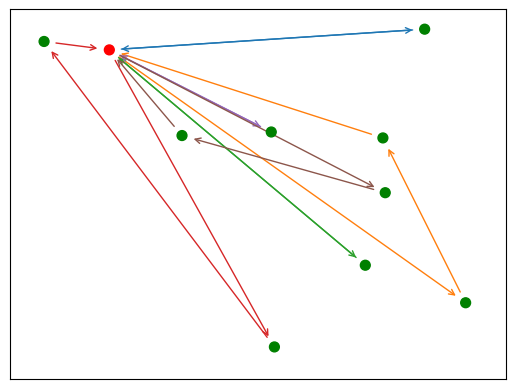

2.6448603115742775


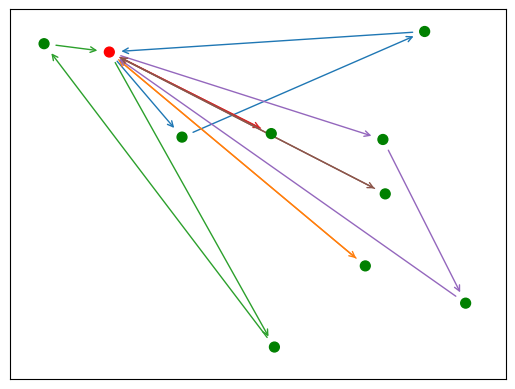

3.0343756566529985


In [6]:
# testing
# vrp = vrps_train[0]
vrp = vrps_test[0]

solver = GurobiSolver(vrp)
solver.solve()
draw_solution(solver)
print(solver.get_actual_objective())
predicted_edge_costs = cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1))
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = predicted_edge_costs[i]
solver = GurobiSolver(vrp)
solver.set_predicted_objective()
solver.solve()
draw_solution(solver)
print(solver.get_actual_objective())

In [7]:
test(cost_model, vrps_test, is_two_stage=False)

Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_800, accuracy: 0.6, actual cost: 2.6448603115742775, predicted cost: 3.0343756566529985
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_801, accuracy: 0.7, actual cost: 4.030417935363649, predicted cost: 6.341648217146855
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_802, accuracy: 0.9727272727272727, actual cost: 5.575644970307709, predicted cost: 10.639927819448005
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_803, accuracy: 1.2454545454545454, actual cost: 7.354883805796964, predicted cost: 14.51548948439739
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_804, accuracy: 1.3363636363636362, actual cost: 8.133683831907561, predicted cost: 15.637598333193699
Parsed instance VRP instance: ../data/cvrp_1000_10_5_2/instance_805, accuracy: 1.5863636363636362, actual cost: 10.03959145482758, predicted cost: 18.551297860386534
Parsed instance VRP instance: ../da